# Fine-tuning DistilBERT for Movie Review Sentiment Analysis and Simulating RLHF with GPT-2

In this notebook, we'll explore an advanced application of natural language processing and machine learning: combining sentiment analysis with a simplified simulation of Reinforcement Learning from Human Feedback (RLHF). This process will consist of two main parts:

1. Fine-tuning a pre-trained sentiment analysis model
2. Using this model to simulate RLHF for training a language model

We use the [TRL library](https://huggingface.co/docs/trl/en/index) from Hugging Face. TRL is a full stack library where we provide a set of tools to train transformer language models with Reinforcement Learning, from the Supervised Fine-tuning step (SFT), Reward Modeling step (RM) to the Proximal Policy Optimization (PPO) step. The library is integrated with 🤗 transformers.

## Part 1: Fine-tuning DistilBERT for Movie Review Sentiment Analysis

We'll start by fine-tuning the `distilbert-base-uncased-finetuned-sst-2-english` model on the [IMDB dataset](https://huggingface.co/datasets/stanfordnlp/imdb) from Stanford NLP hosted on Hugging Face. This model, already trained on the Stanford Sentiment Treebank, provides a strong starting point for sentiment analysis. By fine-tuning it on IMDB movie reviews, we'll create a sentiment analyzer specifically tailored to movie review language.

Key steps:
- Loading the IMDB dataset from Hugging Face
- Preparing the data for fine-tuning
- Fine-tuning the DistilBERT model
- Evaluating the fine-tuned model's performance

## Part 2: Simulating RLHF with GPT-2 using PPO and the TRL library

Once we have our fine-tuned sentiment analysis model, we'll use it as a proxy for human feedback in a simplified RLHF-like setup to train GPT-2. This process will guide GPT-2 to generate more positive movie reviews, demonstrating key RLHF concepts within practical time and resource constraints.

Key steps:
- Setting up the simulated RLHF environment using the TRL (Transformer Reinforcement Learning) library
- Defining a reward function using our fine-tuned sentiment analyzer as a stand-in for human feedback
- Training GPT-2 using PPO
- Evaluating the results by comparing original GPT-2 outputs with the RLHF-simulated model

Important Note: This implementation uses pre-existing labeled data instead of real-time human feedback, offering a practical demonstration of RLHF concepts. While not a full RLHF implementation, it provides valuable insights into the principles of aligning language models with specific criteria using reinforcement learning techniques.

By the end of this notebook, you'll have a deeper understanding of how to leverage pre-trained models, fine-tune them for specific tasks, and explore the concepts of using feedback to guide the behavior of language models.

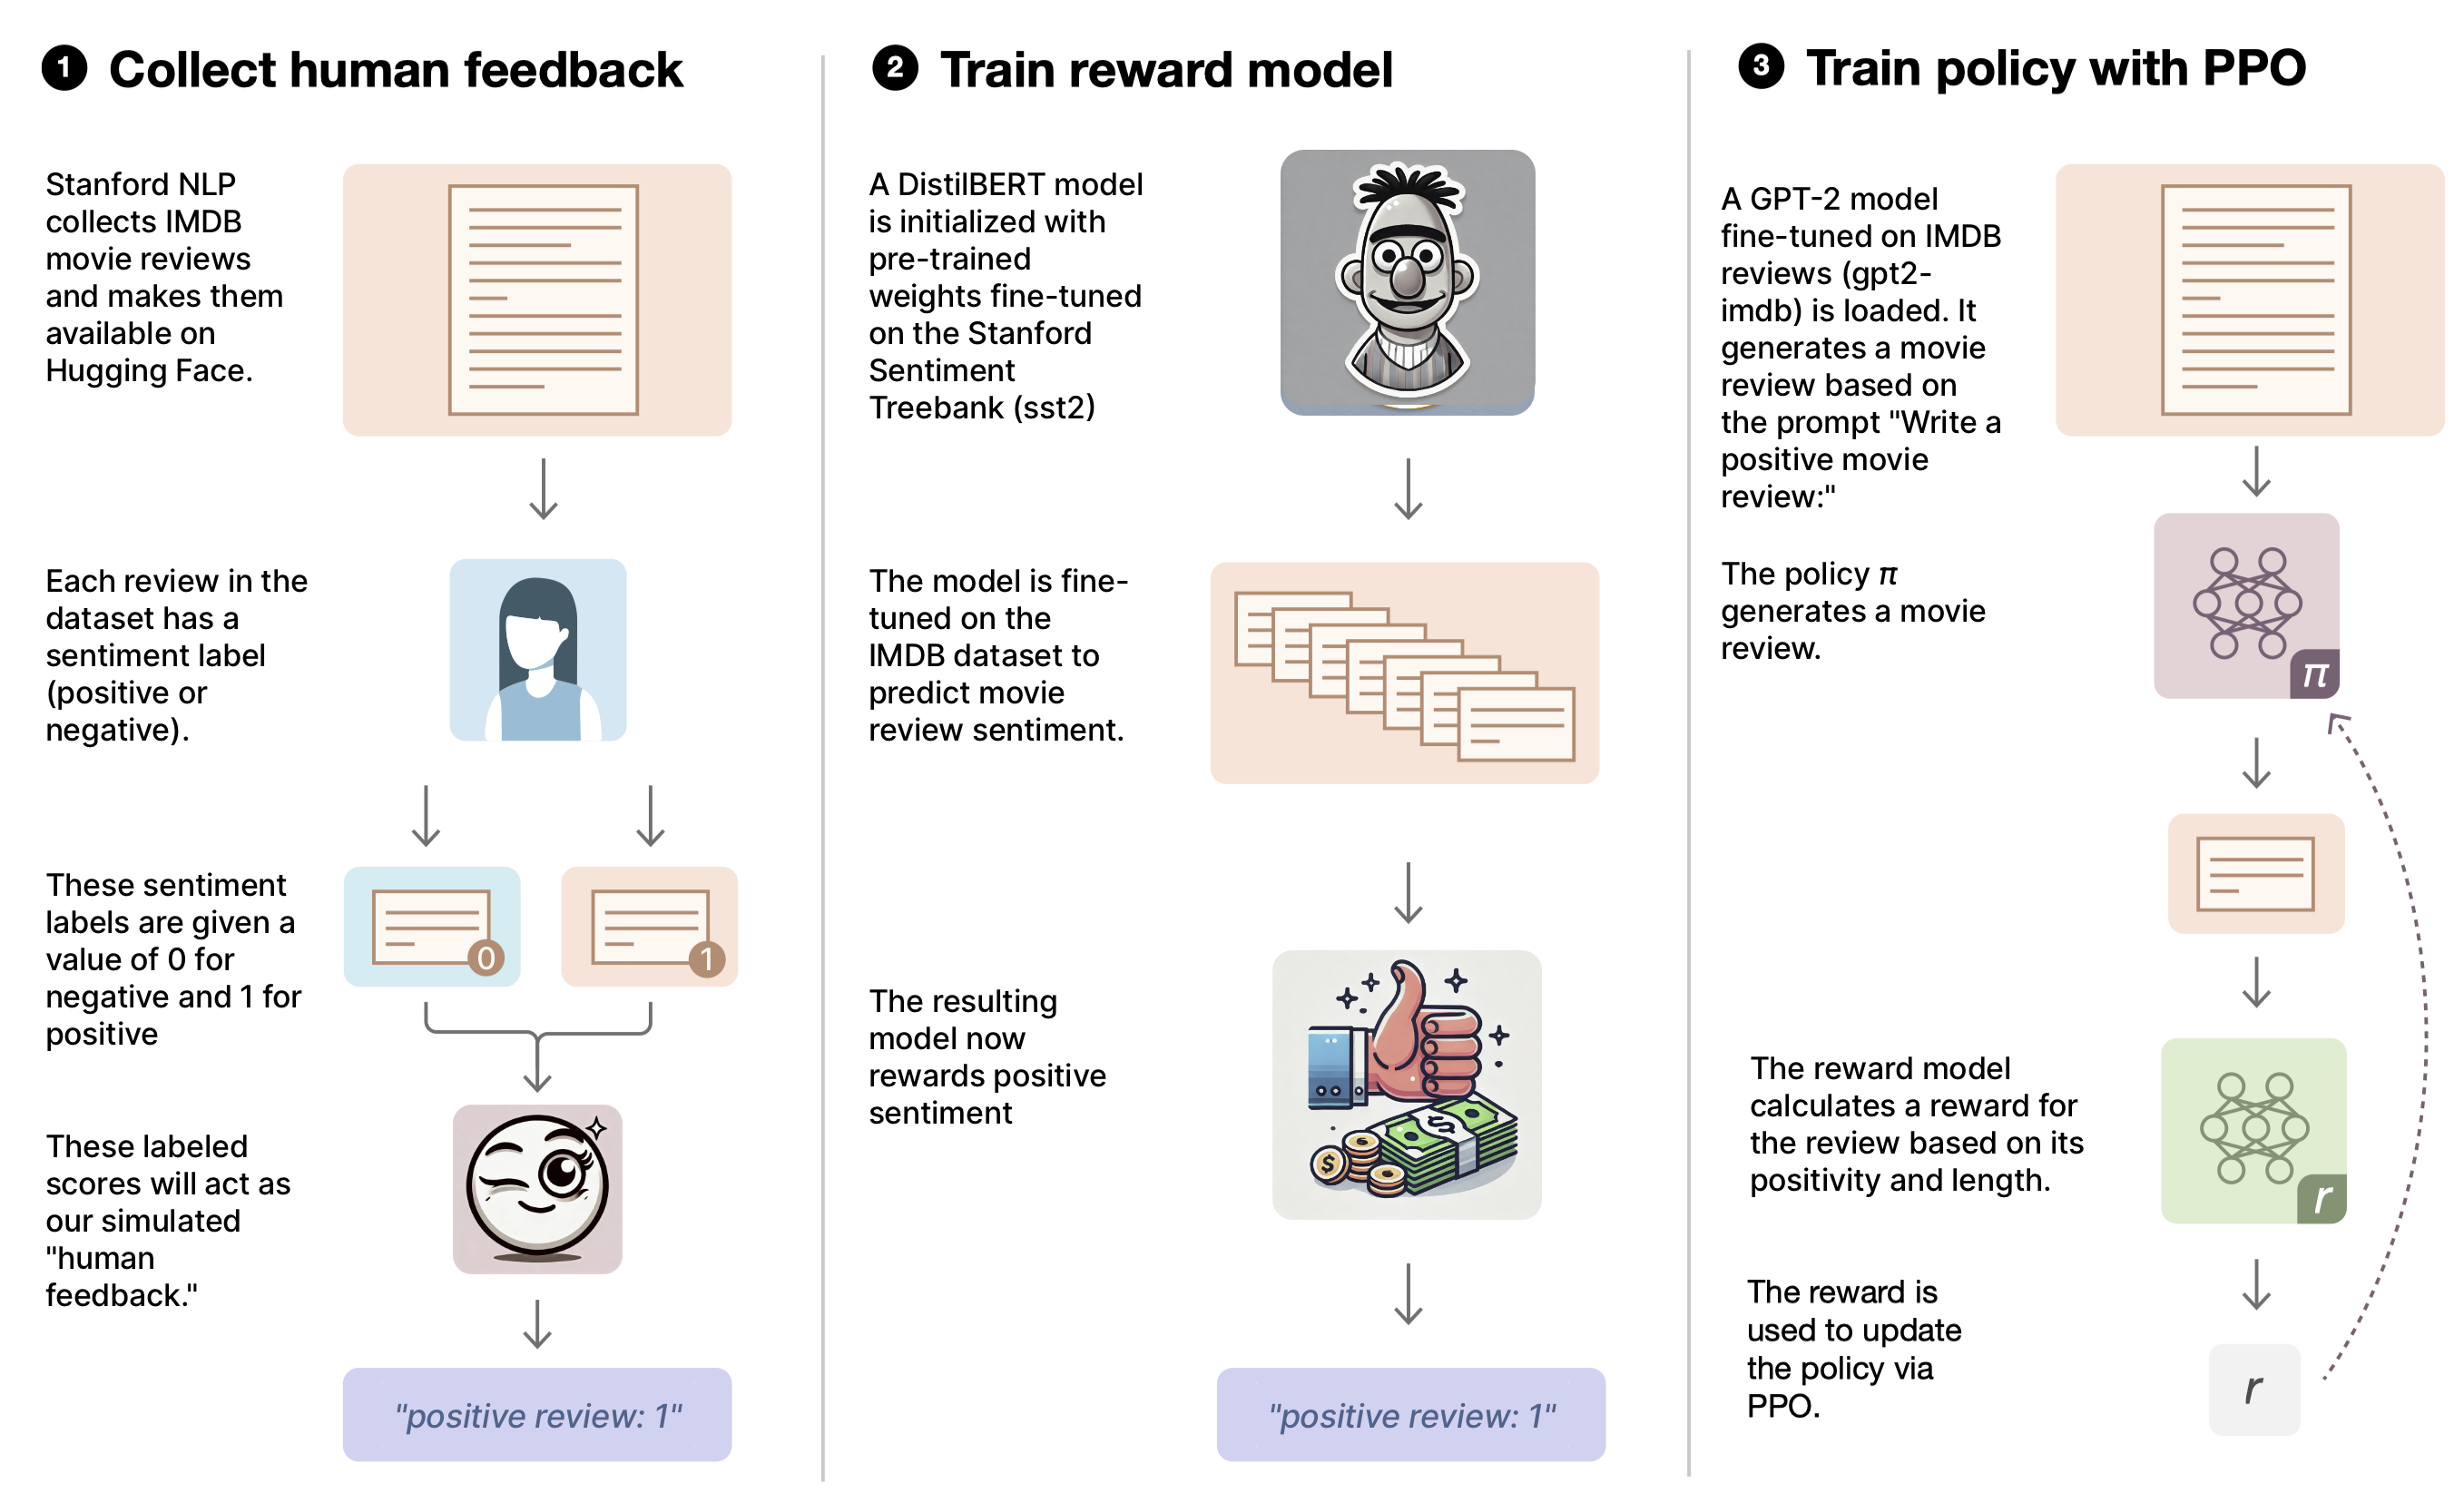

In [ ]:
# Output has been cleared for better readability
!pip install trl transformers pyarrow fsspec requests --upgrade

In [ ]:
import torch
import torch.nn as nn
import warnings
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModelForSequenceClassification, logging, pipeline, Trainer, TrainingArguments
from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead
from trl.core import LengthSampler

# Suppress warnings and set logging
warnings.filterwarnings("ignore", message="Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.")
logging.set_verbosity_error()

# Determine the device CUDA (GPU) or CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Fine-tuning a Sentiment Analysis Model for Simulated RLHF

This code demonstrates the process of fine-tuning a pre-trained sentiment analysis model on the IMDB dataset. The fine-tuned model will later serve as a proxy for human feedback in our simulated RLHF setup.

## Data Preparation

The process begins by loading the IMDB dataset, which contains movie reviews labeled as positive or negative. These pre-existing labels will serve as our "human feedback" for sentiment analysis.

## Model Initialization

We start with a pre-trained model, "distilbert-base-uncased-finetuned-sst-2-english", which has already been trained on sentiment analysis tasks. We modify its architecture slightly:

- The model is initialized with two output labels (positive and negative).
- We then modify the classifier layer to output a single value, transforming the task from classification to regression. This allows the model to output a continuous sentiment score rather than a binary classification.

## Data Processing

The dataset is then processed:

1. Each review is tokenized (converted to a sequence of token IDs that the model can understand).
2. The labels are converted to floats and reshaped to match the model's new output format.
3. The dataset is split into training and validation sets.

## Training Setup

The training process is configured with specific hyperparameters:

- We use a relatively small learning rate (1e-5) to fine-tune the pre-trained model gently.
- The training runs for 3 epochs, with periodic evaluation and model saving.
- We implement a warmup period and weight decay to improve training stability and generalization.

## Model Training

With everything set up, we initiate the fine-tuning process. The model is trained on the prepared dataset, periodically evaluated on the validation set, and the best-performing version is saved.

## Final Steps

After training, the fine-tuned model is moved to the appropriate device (GPU if available, otherwise CPU) for efficient inference.

This fine-tuned model will now be capable of assigning sentiment scores to movie reviews. In our simulated RLHF process, it will act as a stand-in for human feedback, providing a reward signal to guide the training of GPT-2 towards generating more positive reviews.

In [ ]:
# Load and prepare data
print("Loading IMDB dataset...")
dataset = load_dataset("imdb", split="train")
print("Dataset loaded successfully.")

def train_reward_model(dataset):
    print("Initializing pre-trained sentiment model and tokenizer...")
    model_name = "distilbert-base-uncased-finetuned-sst-2-english"
    reward_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2, ignore_mismatched_sizes=True)
    reward_tokenizer = AutoTokenizer.from_pretrained(model_name)
    print("Pre-trained sentiment model and tokenizer initialized.")

    # Modify the classifier to output a single value
    reward_model.classifier = nn.Linear(reward_model.classifier.in_features, 1)

    def tokenize_and_format(examples):
        tokenized = reward_tokenizer(examples["text"], padding="max_length", truncation=True, max_length=512)
        # Convert labels to float and reshape to match model output [batch_size, 1]
        tokenized["labels"] = [[float(label)] for label in examples["label"]]
        return tokenized

    print("Tokenizing and formatting dataset...")
    tokenized_dataset = dataset.map(tokenize_and_format, batched=True, remove_columns=dataset.column_names)
    print("Dataset tokenization and formatting completed.")

    # Training setup recommended by Hugging Face
    training_args = TrainingArguments(
        output_dir="./results",
        num_train_epochs=3.0,
        per_device_train_batch_size=32,
        per_device_eval_batch_size=64,
        warmup_steps=600,
        weight_decay=0.01,
        logging_dir="./logs",
        logging_steps=100,
        learning_rate=1e-5,
        save_steps=1000,
        eval_steps=1000,
        eval_strategy="steps",
        load_best_model_at_end=True,
    )

    # Split the dataset into train and validation
    tokenized_dataset = tokenized_dataset.train_test_split(test_size=0.1)

    trainer = Trainer(
        model=reward_model,
        args=training_args,
        train_dataset=tokenized_dataset["train"],
        eval_dataset=tokenized_dataset["test"],
        tokenizer=reward_tokenizer,
    )

    print("Starting reward model fine-tuning...")
    trainer.train()
    print("Reward model fine-tuning completed.")
    return reward_model, reward_tokenizer

print("Initiating reward model fine-tuning process...")
reward_model, reward_tokenizer = train_reward_model(dataset)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
reward_model = reward_model.to(device)
print("Reward model successfully fine-tuned and moved to device.")

Loading IMDB dataset...
Dataset loaded successfully.
Initiating reward model fine-tuning process...
Initializing pre-trained sentiment model and tokenizer...
Pre-trained sentiment model and tokenizer initialized.
Tokenizing and formatting dataset...
Dataset tokenization and formatting completed.
Starting reward model fine-tuning...
{'loss': 0.6161, 'grad_norm': 3.5805742740631104, 'learning_rate': 1.6666666666666667e-06, 'epoch': 0.14204545454545456}
{'loss': 0.4101, 'grad_norm': 4.415463924407959, 'learning_rate': 3.3333333333333333e-06, 'epoch': 0.2840909090909091}
{'loss': 0.2903, 'grad_norm': 3.811166763305664, 'learning_rate': 5e-06, 'epoch': 0.42613636363636365}
{'loss': 0.2441, 'grad_norm': 5.325866222381592, 'learning_rate': 6.666666666666667e-06, 'epoch': 0.5681818181818182}
{'loss': 0.2341, 'grad_norm': 6.01873779296875, 'learning_rate': 8.333333333333334e-06, 'epoch': 0.7102272727272727}
{'loss': 0.2368, 'grad_norm': 2.3608202934265137, 'learning_rate': 1e-05, 'epoch': 0.852

# Testing the Fine-tuned Sentiment Analysis Model

This code demonstrates how to use the fine-tuned DistilBERT model to analyze the sentiment of movie reviews. It provides a pipeline for processing reviews, interpreting sentiment scores, and presenting the results in a readable format.

## Sentiment Score Calculation

The `get_sentiment_scores` function serves as the interface to our fine-tuned model:

1. It takes in one or more review texts.
2. The reviews are tokenized and prepared for the model.
3. The model processes these inputs and outputs raw sentiment scores.

This function handles both single reviews and batches of reviews.

## Score Interpretation

The `interpret_score` function translates the raw numerical scores into human-readable interpretations. It categorizes the sentiment into five levels, from "very negative" to "very positive", based on predefined thresholds.

## Score Normalization

To provide an alternative representation of the sentiment, the `normalize_score` function applies a sigmoid transformation to the raw scores. This maps the unbounded raw scores to a 0-1 range, which can be interpreted as a "positivity probability". I did find that this was less useful when training RLHF, but it's helpful to gauge the sentiment.

## Review Analysis Pipeline

The `analyze_reviews` function ties everything together:

1. It processes a list of reviews through the sentiment model.
2. For each review, it compiles a comprehensive result including:
   - The original review text
   - The raw sentiment score
   - A textual interpretation of the sentiment
   - A normalized score between 0 and 1

## Demonstration

The section concludes with a practical demonstration:

1. Two contrasting movie reviews are provided as examples.
2. These reviews are processed through the analysis pipeline.
3. The results are then printed in a formatted manner, showcasing:
   - The full text of each review
   - Its raw sentiment score
   - The interpreted sentiment
   - The normalized sentiment score

This demonstration shows how the model performs on real-world movie reviews, and its ability to distinguish between positive and negative sentiments in nuanced text.

In [ ]:
def get_sentiment_scores(texts):
    inputs = reward_tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = reward_model(**inputs)
        scores = outputs.logits.squeeze().tolist()
    return scores if isinstance(scores, list) else [scores]

def interpret_score(score):
    if score > 3:
        return "very positive"
    elif 1 < score <= 3:
        return "moderately positive"
    elif -1 <= score <= 1:
        return "neutral or mixed"
    elif -3 <= score < -1:
        return "moderately negative"
    else:
        return "very negative"

def normalize_score(score):
    return 1 / (1 + torch.exp(-torch.tensor(score))).item()

def analyze_reviews(reviews):
    sentiment_scores = get_sentiment_scores(reviews)

    results = []
    for review, score in zip(reviews, sentiment_scores):
        interpretation = interpret_score(score)
        normalized_score = normalize_score(score)

        result = {
            "review": review,
            "raw_score": score,
            "interpretation": interpretation,
            "normalized_score": normalized_score
        }
        results.append(result)

    return results

# Example usage
reviews = [
    """Zentropa is the most original movie I've seen in years. If you like unique thrillers that are influenced by film noir, then this is just the right cure for all of those Hollywood summer blockbusters clogging the theaters these days. Von Trier's follow-ups like Breaking the Waves have gotten more acclaim, but this is really his best work. It is flashy without being distracting and offers the perfect combination of suspense and dark humor. It's too bad he decided handheld cameras were the wave of the future. It's hard to say who talked him away from the style he exhibits here, but it's everyone's loss that he went into his heavily theoretical dogma direction instead.""",
    """I've never been so bored in my life. The plot was predictable, the acting was wooden, and the special effects looked like they were done on a home computer. I can't believe I wasted two hours of my life on this garbage. Avoid at all costs."""
]

analysis_results = analyze_reviews(reviews)

for i, result in enumerate(analysis_results, 1):
    print(f"\nReview {i}:")
    print(f"Review text: {result['review']}")
    print(f"Raw sentiment score: {result['raw_score']:.4f}")
    print(f"Interpretation: The review is {result['interpretation']}.")
    print(f"Normalized score (0 to 1 scale): {result['normalized_score']:.4f}")
    print("-" * 50)


Review 1:
Review text: Zentropa is the most original movie I've seen in years. If you like unique thrillers that are influenced by film noir, then this is just the right cure for all of those Hollywood summer blockbusters clogging the theaters these days. Von Trier's follow-ups like Breaking the Waves have gotten more acclaim, but this is really his best work. It is flashy without being distracting and offers the perfect combination of suspense and dark humor. It's too bad he decided handheld cameras were the wave of the future. It's hard to say who talked him away from the style he exhibits here, but it's everyone's loss that he went into his heavily theoretical dogma direction instead.
Raw sentiment score: 4.1652
Interpretation: The review is very positive.
Normalized score (0 to 1 scale): 0.9847
--------------------------------------------------

Review 2:
Review text: I've never been so bored in my life. The plot was predictable, the acting was wooden, and the special effects look

# Implementing RLHF with GPT-2 for Positive Movie Review Generation

This code demonstrates the implementation of RLHF to fine-tune a GPT-2 model for generating positive movie reviews. The process involves several key components:

## Reward Computation

The `compute_rewards` function serves as the core of the RLHF process:

1. It uses the previously fine-tuned sentiment analysis model to score generated texts.
2. It incorporates a length bonus to encourage longer reviews.
3. The final reward combines the sentiment score and length bonus, providing a comprehensive evaluation of the generated text.

## Model and Trainer Initialization

1. A pre-trained GPT-2 model (specifically trained on IMDB reviews) is loaded as the base model.
2. A reference model is created to stabilize training.
3. The models are configured for token padding and moved to the appropriate device (CPU/GPU).
4. A PPO (Proximal Policy Optimization) trainer is initialized with specific hyperparameters to guide the RLHF process.

The PPO trainer is configured with the following parameters:

```python
ppo_config = PPOConfig(
    batch_size=16,
    learning_rate=5e-8,
    mini_batch_size=4,
    ppo_epochs=3,
    init_kl_coef=0.3,
    target_kl=0.25,
    kl_penalty="kl",
    max_grad_norm=0.5,
)
```

These parameters control various aspects of the PPO algorithm:
- `batch_size`: The number of samples processed in each training step.
- `learning_rate`: The step size for updating model parameters. We use a *very* small learning rate for this task.
- `mini_batch_size`: The size of mini-batches used in each PPO epoch.
- `ppo_epochs`: The number of optimization epochs per PPO update.
- `init_kl_coef` and `target_kl`: Control the Kullback-Leibler divergence between the updated policy and the initial policy.
- `kl_penalty`: The type of KL penalty applied.
- `max_grad_norm`: Clips the gradient norm to prevent extreme updates.

## Training Loop

The training process occurs over a specified number of epochs and batches:

1. For each batch, the model generates a set of movie reviews based on a prompt.
2. These generated reviews are evaluated using the reward function.
3. The PPO algorithm uses these rewards to update the model, encouraging it to generate reviews that receive higher rewards.
4. Various metrics (mean reward, KL divergence, policy loss, value loss) are tracked throughout training.
5. Periodic updates are printed to monitor the training progress.

### Text Generation Parameters

During the training loop, movie reviews are generated using the following parameters:

```python
response = ppo_trainer.generate(
    encoded_prompt,
    attention_mask=attention_mask,
    min_length=40,
    max_new_tokens=response_length,
    do_sample=True,
    temperature=0.6,
    top_k=40,
    top_p=0.9,
    no_repeat_ngram_size=3,
    repetition_penalty=1.3,
)
```

These parameters control the text generation process:
- `min_length`: Ensures generated reviews are at least 40 tokens long.
- `max_new_tokens`: Limits the maximum length of generated text.
- `do_sample`: Enables sampling-based generation (as opposed to greedy decoding).
- `temperature`: Controls randomness in sampling (lower values make output more deterministic).
- `top_k` and `top_p`: Limit the pool of next-word candidates to control output quality.
- `no_repeat_ngram_size`: Prevents repetition of n-grams.
- `repetition_penalty`: Further discourages repetitive text.

## Evaluation

After training, the RLHF-tuned model is evaluated against the original model:

1. Both models generate a review based on the same prompt.
2. The outputs are displayed for comparison.
3. The reward function is applied to both outputs to quantitatively compare their performance.

This process demonstrates how RLHF can be used to guide a language model towards generating content that aligns with specific criteria--in this case, positive movie reviews.


In [ ]:
def compute_rewards(texts):
    # Tokenize and get sentiment scores
    inputs = reward_tokenizer(texts, return_tensors="pt", padding=True, truncation=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = reward_model(**inputs)
        sentiment_scores = outputs.logits.squeeze(-1)

    # Calculate length bonuses
    length_bonuses = torch.tensor([min(len(text.split()) / 50, 1) for text in texts], device=device)

    # Combine sentiment scores with length bonuses
    combined_scores = torch.sigmoid(sentiment_scores) + 0.5 * length_bonuses

    return combined_scores.tolist()

# Initialize models and tokenizer
print("Initializing main model, reference model, and tokenizer...")
model_name = "lvwerra/gpt2-imdb"
model = AutoModelForCausalLMWithValueHead.from_pretrained(model_name)
ref_model = AutoModelForCausalLMWithValueHead.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.pad_token = tokenizer.eos_token

# Set pad_token_id explicitly for both models
model.config.pad_token_id = tokenizer.eos_token_id
ref_model.config.pad_token_id = tokenizer.eos_token_id

# Move models to device after setting pad_token_id
model = model.to(device)
ref_model = ref_model.to(device)
print("Models and tokenizer initialized and moved to device.")

# Configure PPO training
print("Configuring PPO training...")
ppo_config = PPOConfig(
    batch_size=16,
    learning_rate=5e-8,
    mini_batch_size=4,
    ppo_epochs=3,
    init_kl_coef=0.3,
    target_kl=0.25,
    kl_penalty="kl",
    max_grad_norm=0.5,
)

# Initialize PPO Trainer
print("Initializing PPO Trainer...")
ppo_trainer = PPOTrainer(
    config=ppo_config,
    model=model,
    ref_model=ref_model,
    tokenizer=tokenizer,
)
print("PPO Trainer initialized.")

# Track metrics
metrics_history = {
    'mean_reward': [],
    'kl_divergence': [],
    'policy_loss': [],
    'value_loss': []
}

# Training loop
num_epochs = 1
batches_per_epoch = 50

prompt = "Write a positive movie review:"
encoded_prompt = tokenizer.encode(prompt, return_tensors="pt").squeeze(0).to(device)
attention_mask = torch.ones((1, encoded_prompt.size(0)), dtype=torch.long).to(device)

# Create a length sampler for response generation
length_sampler = LengthSampler(40, 100)

print("Starting main training loop...")
for epoch in range(num_epochs):
    print(f"Beginning Epoch {epoch + 1}/{num_epochs}")
    epoch_stats = []
    for batch in range(batches_per_epoch):
        # Generate responses
        response_tensors = []
        for _ in range(ppo_config.batch_size):
            response_length = length_sampler()
            response = ppo_trainer.generate(
                encoded_prompt,
                attention_mask=attention_mask,
                min_length=40,
                max_new_tokens=response_length,
                do_sample=True,
                temperature=0.6,
                top_k=40,
                top_p=0.9,
                no_repeat_ngram_size=3,
                repetition_penalty=1.3,
            )
            response_tensors.append(response.squeeze(0))

        # Decode responses
        response_texts = tokenizer.batch_decode(response_tensors, skip_special_tokens=True)

        # Calculate rewards for generated texts
        rewards = compute_rewards(response_texts)

        reward_tensors = [torch.tensor(reward, device=device) for reward in rewards]

        # Prepare inputs for PPO step
        query_tensors = [encoded_prompt] * ppo_config.batch_size

        # Perform PPO step
        stats = ppo_trainer.step(query_tensors, response_tensors, reward_tensors)
        epoch_stats.append(stats)

        # Track metrics
        metrics_history['mean_reward'].append(stats['ppo/mean_scores'])
        metrics_history['kl_divergence'].append(abs(stats.get('objective/kl', 0)))
        metrics_history['policy_loss'].append(stats.get('ppo/loss/policy', 0))
        metrics_history['value_loss'].append(stats.get('ppo/loss/value', 0))

        if batch % 5 == 0:
            print(f"Epoch {epoch + 1}/{num_epochs}, Batch {batch + 1}/{batches_per_epoch}")
            print(f"Mean reward: {stats['ppo/mean_scores']:.4f}")
            print(f"KL divergence: {abs(stats.get('objective/kl', 0)):.4f}")
            print(f"Policy loss: {stats.get('ppo/loss/policy', 'N/A'):.4f}")
            print(f"Value loss: {stats.get('ppo/loss/value', 'N/A'):.4f}")
            print("Sample output:", response_texts[0])
            print("------------------")

    print(f"Epoch {epoch + 1}/{num_epochs} completed")
    mean_reward = sum(s['ppo/mean_scores'] for s in epoch_stats) / len(epoch_stats)
    print(f"Mean epoch reward: {mean_reward:.4f}")
    print("====================")

print("Training completed. Starting evaluation...")

# Evaluate
print("Loading original model for comparison...")
original_model = AutoModelForCausalLM.from_pretrained(model_name).to(device)
rlhf_model = ppo_trainer.model.pretrained_model
print("Models loaded successfully.")

# Compare outputs
test_prompt = "Write a positive movie review:"
input_ids = tokenizer(test_prompt, return_tensors="pt").input_ids.to(device)

print("\nGenerating review with original model...")
original_output = tokenizer.decode(original_model.generate(input_ids, max_new_tokens=100, do_sample=True, temperature=0.7, no_repeat_ngram_size=3, repetition_penalty=1.2)[0])
print("Original model output:", original_output)

print("\nGenerating review with RLHF model...")
rlhf_output = tokenizer.decode(rlhf_model.generate(input_ids, max_new_tokens=100, do_sample=True, temperature=0.7, no_repeat_ngram_size=3, repetition_penalty=1.2)[0])
print("RLHF model output:", rlhf_output)

print("\nEvaluation completed.")

# Optional: Compute rewards for both outputs to compare
original_reward = compute_rewards([original_output])[0]
rlhf_reward = compute_rewards([rlhf_output])[0]

print(f"\nReward for original model output: {original_reward:.4f}")
print(f"Reward for RLHF model output: {rlhf_reward:.4f}")

print("\nTraining and evaluation process completed.")

Initializing main model, reference model, and tokenizer...
Models and tokenizer initialized and moved to device.
Configuring PPO training...
Initializing PPO Trainer...
PPO Trainer initialized.
Starting main training loop...
Beginning Epoch 1/1
Epoch 1/1, Batch 1/50
Mean reward: 1.1223
KL divergence: 0.0000
Policy loss: -0.0065
Value loss: 4.1429
Sample output: Write a positive movie review: if you don't like it, then just go see the original. If not for this film's poor script and lousy acting, I would have given it another look!
------------------
Epoch 1/1, Batch 6/50
Mean reward: 1.1405
KL divergence: 0.1321
Policy loss: -0.0037
Value loss: 4.5208
Sample output: Write a positive movie review: I'll say this, because it's so bad. The acting was horrible - the whole plot is ridiculous, and there are some very funny scenes that were not meant to be taken seriously. And they don't even make any effort at all to explain anything about the story or the characters in any way.<br /><br />I'

## Visualization

Visualizing the training process is always extremely helpful in deep learning. It allows you to see how the model's performance (mean reward) changes over time, and the KL divergence plot helps monitor if the model is diverging too much from its initial policy. Policy loss and value loss trends can indicate whether the model is learning effectively, and sudden spikes or drops in any metric can alert you to potential problems in the training process.

Most importantly, the trends apparent in a visualization might suggest when to stop training or adjust hyperparameters.

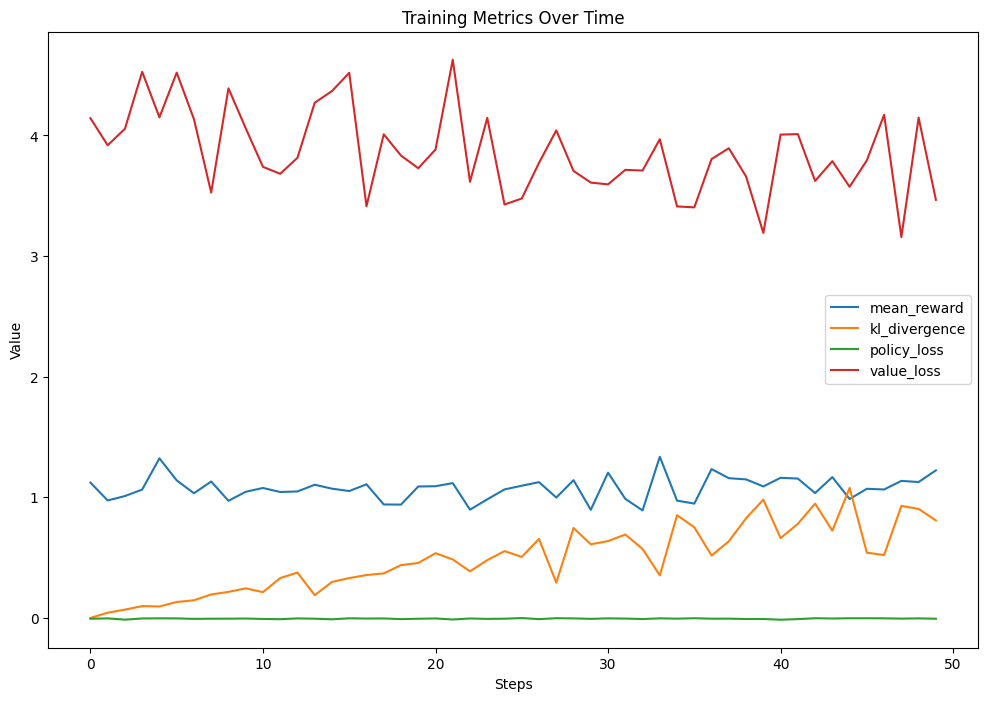

In [ ]:
import matplotlib.pyplot as plt

# After training, plot the metrics
plt.figure(figsize=(12, 8))
for metric, values in metrics_history.items():
    plt.plot(values, label=metric)
plt.legend()
plt.title('Training Metrics Over Time')
plt.xlabel('Steps')
plt.ylabel('Value')
plt.show()

# KL Divergence in RLHF

## What is KL Divergence?

Kullback-Leibler (KL) divergence, also known as relative entropy, is a measure of the difference between two probability distributions. In mathematical terms, for discrete probability distributions P and Q, the KL divergence is defined as:

$$D_{KL}(P \| Q) = \sum_{x \in \mathcal{X}} P(x) \log \left( \frac{P(x)}{Q(x)} \right)$$

## Role in RLHF

In the context of RLHF, KL divergence is used to ensure that the updated policy (the fine-tuned model) doesn't diverge too far from the original policy (the initial model) in a single update step. This helps prevent the "catastrophic forgetting" problem, where the model loses the knowledge it gained previous training. It helps in maintaining a balance between exploring new behaviors and exploiting known good behaviors, and ensures that the model learns gradually, making small improvements in each step rather than drastic changes. By limiting the divergence, we ensure that the model retains its general language understanding while adapting to the specific task, and is more likely to generalize well to unseen inputs.

## Implementation in PPO

In PPO, which is commonly used in RLHF:

1. **KL Penalty**: The `init_kl_coef` parameter sets the initial weight of the KL penalty. This penalty is added to the loss function to discourage large divergences.

2. **Target KL**: The `target_kl` parameter sets a target KL divergence. If the actual KL divergence exceeds this target, the KL penalty is increased, and vice versa.

3. **Adaptive KL Coefficient**: The KL coefficient is adjusted during training based on whether the actual KL divergence is above or below the target.

## 10 examples of the model after RLHF training

In [ ]:
print("\nGenerating 10 reviews with RLHF model...")
for i in range(10):
  rlhf_output = tokenizer.decode(rlhf_model.generate(input_ids, max_new_tokens=100, do_sample=True, temperature=0.7, no_repeat_ngram_size=3, repetition_penalty=1.2)[0])
  print(rlhf_output)


Generating 10 reviews with RLHF model...
Write a positive movie review: If you can't finish it, I suggest that the same go by first. That way the film will be more enjoyable.<br /><br />Overall, this is really good and well done work out of an average 80s horror flick but not bad either.<|endoftext|>
Write a positive movie review: My Dad was the best actor I ever had. I am not an actor, but my daughter is. I like watching movies with her. I have read everything that has been written for this film and liked it so much to watch. It's fun to see how people interact with each other. The story is very good. This isn't a nice little flick about what happens during war.<br /><br />If you want to know more about this series or anything else about the characters in this
Write a positive movie review: here's my take. Let me tell you, I didn't read the script for this one...but I just watched it with an open mind and knew that if you were going to see this film on TV, not in your home theater, t

## 10 examples of the model prior to RLHF training

In [ ]:
print("\nGenerating 10 reviews with Original model...")
for i in range(10):
  original_output = tokenizer.decode(original_model.generate(input_ids, max_new_tokens=100, do_sample=True, temperature=0.7, no_repeat_ngram_size=3, repetition_penalty=1.2)[0])
  print(original_output)


Generating 10 reviews with Original model...
Write a positive movie review: I'm glad that it's so bad. But when you've seen this with the usual friends, and have been given good reasons to dislike it, go ahead and do something about it. It will help more people than just laugh at things they hate (even if there may be some humor in it).<|endoftext|>
Write a positive movie review: don't waste your time reading this trash.<|endoftext|>
Write a positive movie review: this is one of the best movies I have ever seen!<|endoftext|>
Write a positive movie review: Don't be surprised if you find this film to be one of the worst movies I've ever seen.<|endoftext|>
Write a positive movie review:<|endoftext|>
Write a positive movie review: "This is one of the worst movies I've seen in quite some time. It's stupid and it's bad!" No, not so much because of the script, but because of what happens when you have to watch this pile-of rubbish.<br /><br />The acting was awful (I remember hearing that at 

Copyright © Ian Kelk, 2024. Distributed under the MIT License. See `LICENSE` for more information.